In [1]:
import numpy as np
import sklearn.gaussian_process as gp
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from scipy.stats import norm

from bayesian_optimizers.gpr_optimizer import GPROptimizer
from acquisition.acquisition_functions import ProbabilityOfImprovement
sns.set_style("darkgrid")

In [2]:
rand = RandomState(seed=54321)

# Define functions

In [3]:
def objective(X, noise=0.1):
    noise = rand.normal(loc=0, scale=noise, size=X.shape)
    # want to do a minimization, so negate & translate up by 1.5
    return -(X**2 * np.sin(5 * np.pi * X)**6) + 1.5 + noise


def opt_acquisition(surrogate, acquisition, X, rand, sample_size=100):
    # Find best surrogate score so far
    yhat, _ = surrogate.predict(X, return_std=True)
    best = yhat.min()

    # random search of the domain
    X_samp = rand.random(sample_size)[:, np.newaxis]
    
    # find acquisition function value for each sample
    scores = acquisition.acquire(surrogate, X_samp, best)
    
    am = np.argmin(scores)
    return X_samp[am, 0]


def plot_real_sample_vs_surrogate_surface(X, y, model):
    _, ax = plt.subplots()
    
    X_samp = np.arange(0, 1, 0.001)[:, np.newaxis]
    y_samp, _ = model.predict(X_samp, return_std=True)
    sns.scatterplot(X[:, 0], y[:, 0], ax=ax)
    sns.lineplot(X_samp[:, 0], y_samp[:, 0], ax=ax, color="black")
    
    return ax


# Define GPR optimizer

In [4]:
kernel = gp.kernels.RBF()
# Defining the scale parameter here is cheating a bit (since used the same value when generating the data)
gpr = gp.GaussianProcessRegressor(kernel, 
                                  alpha=np.abs(rand.normal(scale=0.1)),
                                  n_restarts_optimizer=10, 
                                  random_state=rand)

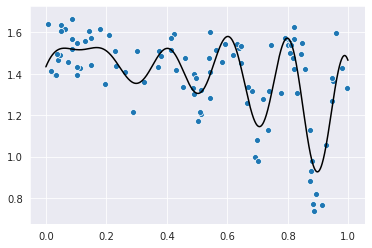

In [5]:
# take a random sample of X values
X = rand.random(100)[:, np.newaxis]
# plug the random sample into the objective
y = objective(X)

gpr_opt = GPROptimizer(gpr, X, y, fit=True)
ax = plot_real_sample_vs_surrogate_surface(X, y, gpr_opt.gpr)
plt.show()

# Find the optimum value of x

In [6]:
acquisition = ProbabilityOfImprovement(epsilon=1e-9)
arg_mn = gpr_opt.optimize(100, objective, lambda model, x: opt_acquisition(model, acquisition, x, rand, sample_size=100))

Best results (found by GP model): x = [0.89799585], y = [0.43846039]


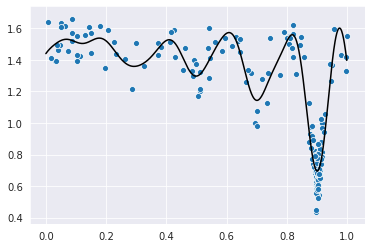

In [7]:
plot_real_sample_vs_surrogate_surface(gpr_opt.X, gpr_opt.y, gpr_opt.gpr)
print(f"Best results (found by GP model): x = {gpr_opt.X[arg_mn]}, y = {gpr_opt.y[arg_mn]}")